In [4]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

c:\Healthcare Readmission Prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Cell 2: Load and quickly explore the data
df = pd.read_csv('../dataset file/diabetic_data.csv')

print("Dataset shape:", df.shape)
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(10))
print("\nTarget variable distribution:")
print(df['readmitted'].value_counts())

Dataset shape: (101766, 50)

Missing values per column:
max_glu_serum               96420
A1Cresult                   84748
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
dtype: int64

Target variable distribution:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64


In [6]:
# Cell 3: Quick data preprocessing
# Select most relevant features based on medical literature to reduce dimensionality
selected_features = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
    'num_medications', 'number_inpatient', 'number_emergency',
    'number_outpatient', 'number_diagnoses', 'age', 'gender',
    'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed'
]

# Create a subset with selected features
df_subset = df[selected_features + ['readmitted']].copy()

# Convert target to binary: readmitted (1) vs not readmitted (0)
df_subset['readmitted_binary'] = df_subset['readmitted'].apply(
    lambda x: 0 if x == 'NO' else 1
)

print("Selected features dataset shape:", df_subset.shape)

Selected features dataset shape: (101766, 17)


In [7]:
# Cell 4: Handle missing values and encode categorical variables
# Simple imputation for missing values
df_clean = df_subset.copy()

# Impute numerical features with median
numerical_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                    'num_medications', 'number_inpatient', 'number_emergency',
                    'number_outpatient', 'number_diagnoses']

for col in numerical_features:
    df_clean[col].fillna(df_clean[col].median(), inplace=True)

# Impute categorical features with mode
categorical_features = ['age', 'gender', 'max_glu_serum', 'A1Cresult', 
                       'insulin', 'change', 'diabetesMed']

for col in categorical_features:
    df_clean[col].fillna(df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown', inplace=True)

# Label encoding for categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le

print("Data cleaning completed. Missing values remaining:", df_clean.isnull().sum().sum())

Data cleaning completed. Missing values remaining: 0


In [8]:
# Cell 5: Prepare features and target for modeling
X = df_clean[selected_features]
y = df_clean['readmitted_binary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Readmission rate - Train: {y_train.mean():.3f}, Test: {y_test.mean():.3f}")

Training set: (71236, 15), Test set: (30530, 15)
Readmission rate - Train: 0.461, Test: 0.461


In [9]:
# Cell 6: Train Random Forest with optimized parameters for speed
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,  # Reduced for speed
    max_depth=10,
    min_samples_split=50,  # Increased for speed
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest trained successfully!")

Training Random Forest...
Random Forest trained successfully!


In [10]:
# Cell 7: Train XGBoost with optimized parameters
print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost trained successfully!")

Training XGBoost...
XGBoost trained successfully!


In [11]:
# Cell 8: Model evaluation metrics
def evaluate_model(name, y_true, y_pred, y_pred_proba):
    print(f"\n{name} Performance:")
    print("="*50)
    print(f"ROC-AUC: {roc_auc_score(y_true, y_pred_proba):.4f}")
    print(f"Brier Score: {brier_score_loss(y_true, y_pred_proba):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

evaluate_model("Random Forest", y_test, rf_pred, rf_pred_proba)
evaluate_model("XGBoost", y_test, xgb_pred, xgb_pred_proba)


Random Forest Performance:
ROC-AUC: 0.6697
Brier Score: 0.2268

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.76      0.69     16459
           1       0.63      0.48      0.54     14071

    accuracy                           0.63     30530
   macro avg       0.63      0.62      0.61     30530
weighted avg       0.63      0.63      0.62     30530


XGBoost Performance:
ROC-AUC: 0.6720
Brier Score: 0.2256

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.75      0.69     16459
           1       0.63      0.49      0.55     14071

    accuracy                           0.63     30530
   macro avg       0.63      0.62      0.62     30530
weighted avg       0.63      0.63      0.62     30530



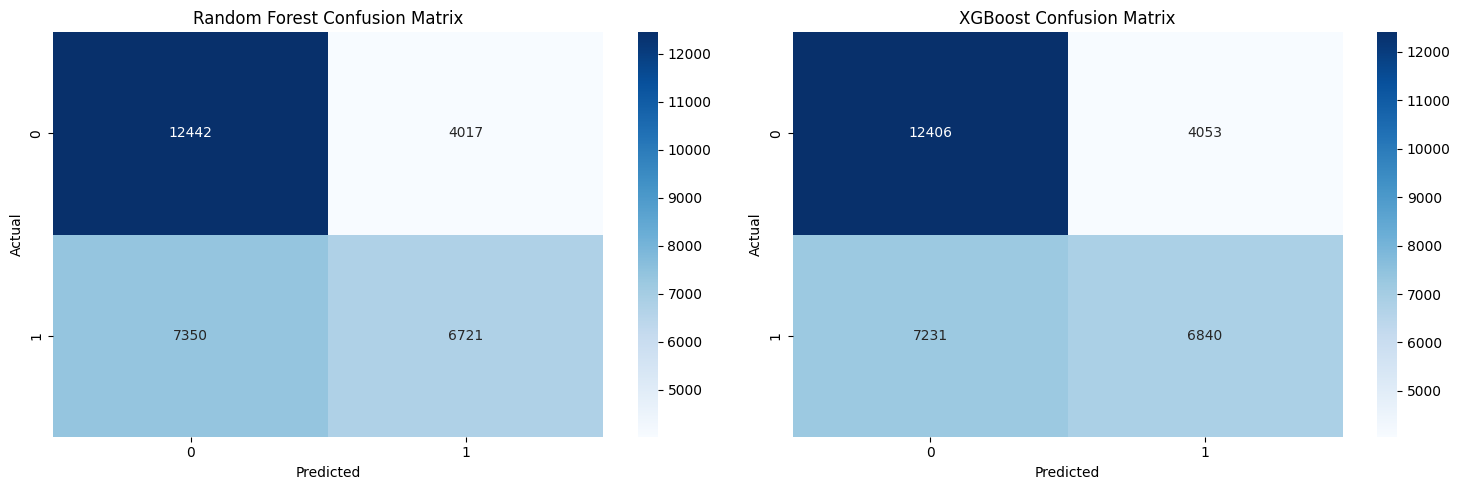

In [12]:
# Cell 9: Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Random Forest Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# XGBoost Confusion Matrix
cm_xgb = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('XGBoost Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

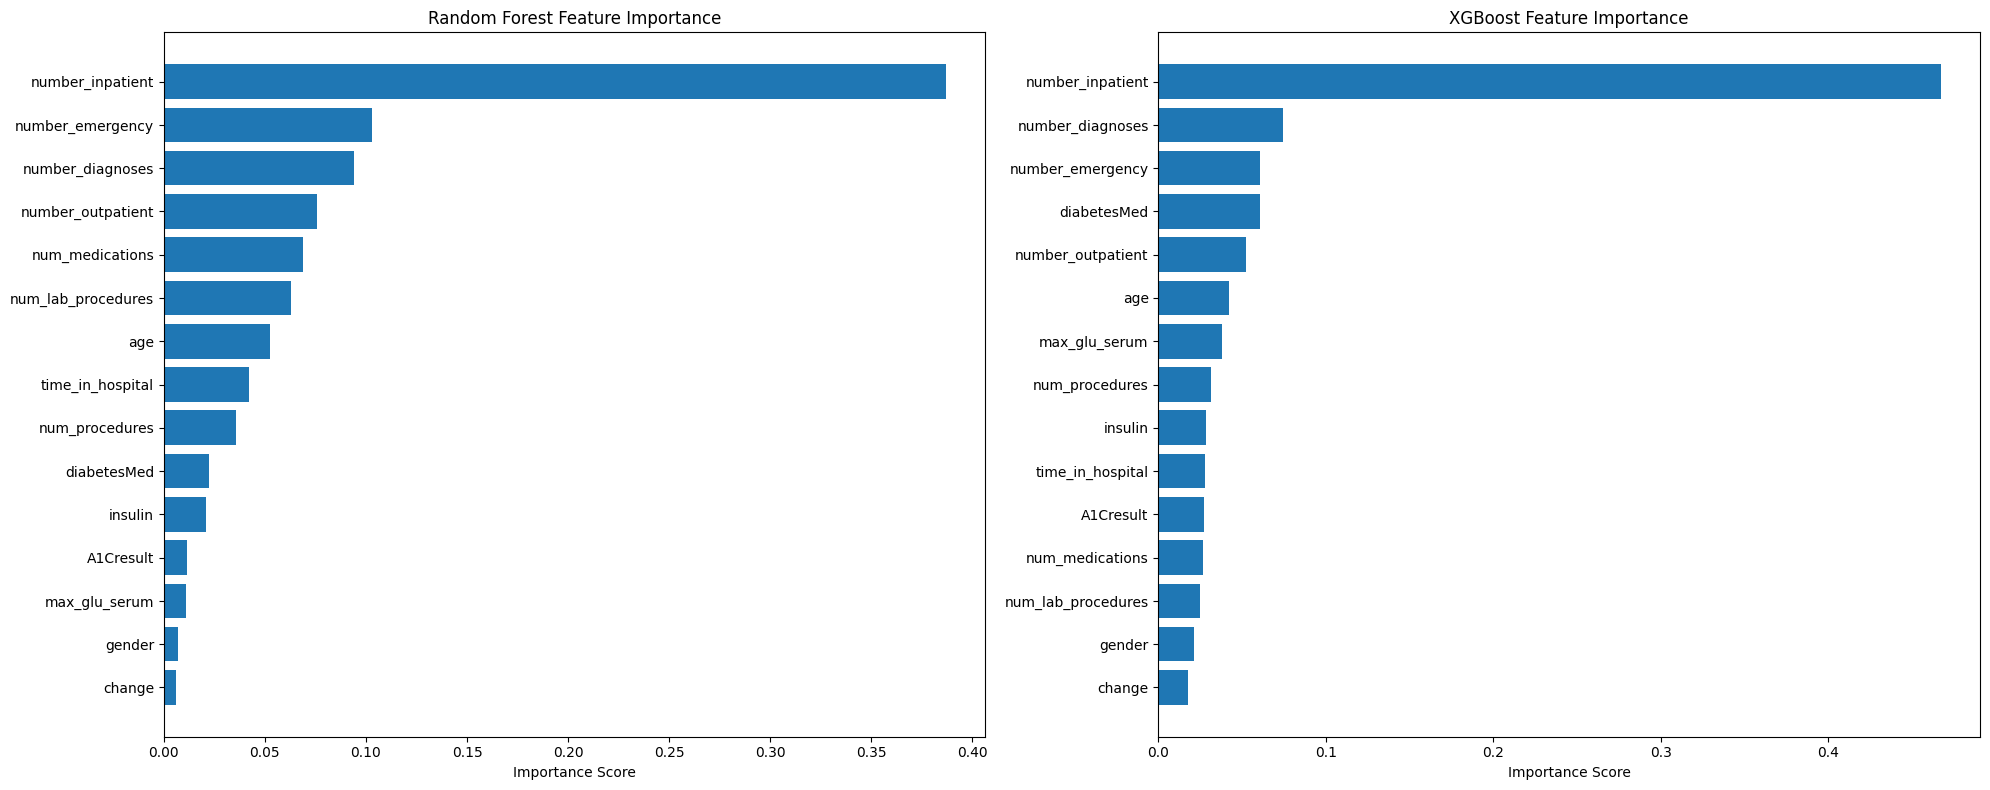

In [13]:
# Cell 10: Feature importance analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

ax1.barh(rf_importance['feature'], rf_importance['importance'])
ax1.set_title('Random Forest Feature Importance')
ax1.set_xlabel('Importance Score')

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=True)

ax2.barh(xgb_importance['feature'], xgb_importance['importance'])
ax2.set_title('XGBoost Feature Importance')
ax2.set_xlabel('Importance Score')

plt.tight_layout()
plt.show()

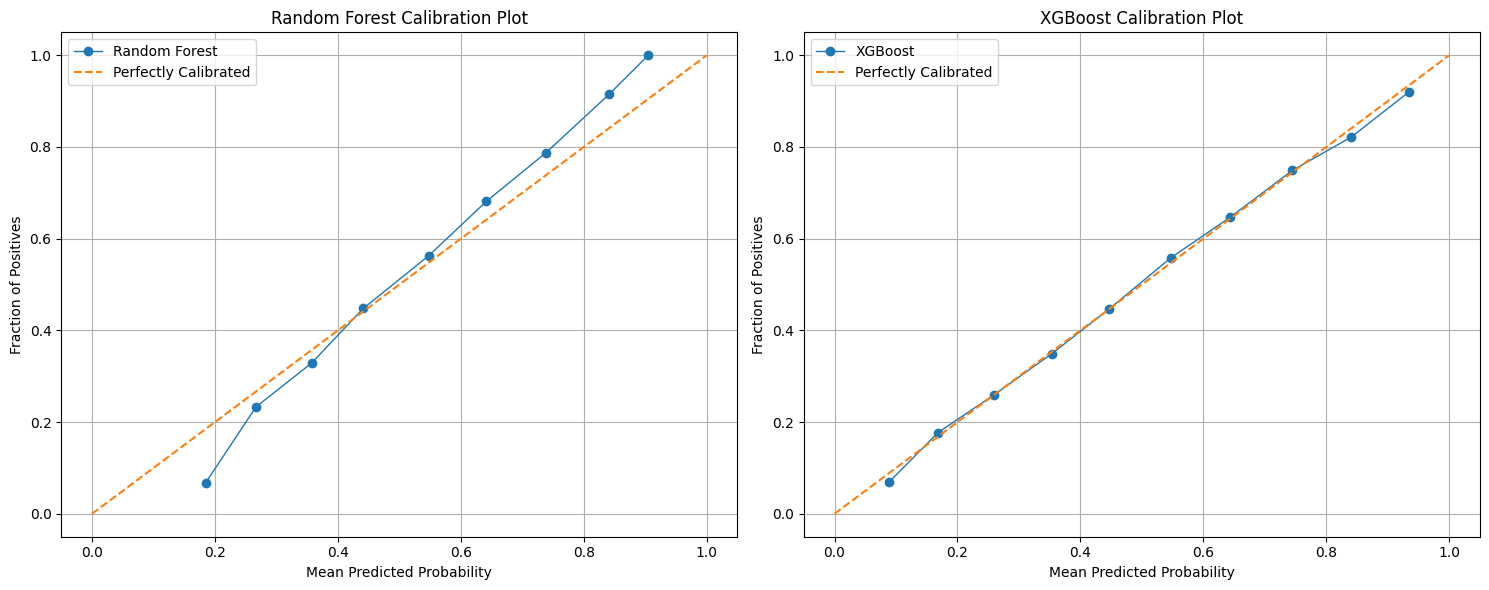

In [14]:
# Cell 11: Calibration plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Random Forest Calibration
fop_rf, mpv_rf = calibration_curve(y_test, rf_pred_proba, n_bins=10)
ax1.plot(mpv_rf, fop_rf, marker='o', linewidth=1, label='Random Forest')
ax1.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
ax1.set_xlabel('Mean Predicted Probability')
ax1.set_ylabel('Fraction of Positives')
ax1.set_title('Random Forest Calibration Plot')
ax1.legend()
ax1.grid(True)

# XGBoost Calibration
fop_xgb, mpv_xgb = calibration_curve(y_test, xgb_pred_proba, n_bins=10)
ax2.plot(mpv_xgb, fop_xgb, marker='o', linewidth=1, label='XGBoost')
ax2.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
ax2.set_xlabel('Mean Predicted Probability')
ax2.set_ylabel('Fraction of Positives')
ax2.set_title('XGBoost Calibration Plot')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

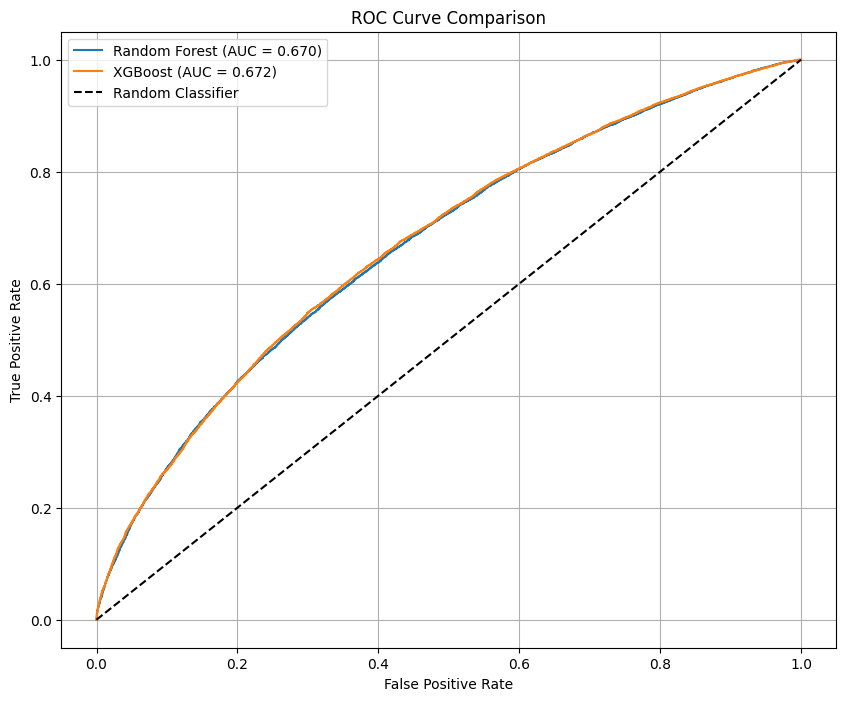

In [15]:
# Cell 12: ROC Curve comparison
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, rf_pred_proba):.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Cell 13: Clinical utility analysis - Risk stratification
def risk_stratification_analysis(model_name, probabilities, threshold=0.3):
    high_risk = (probabilities >= threshold).sum()
    total = len(probabilities)
    print(f"\n{model_name} Risk Stratification (Threshold: {threshold}):")
    print(f"High-risk patients identified: {high_risk}/{total} ({high_risk/total*100:.1f}%)")
    
    # Among high-risk, how many actually readmitted
    high_risk_actual = ((probabilities >= threshold) & (y_test == 1)).sum()
    if high_risk > 0:
        precision = high_risk_actual / high_risk
        print(f"Precision in high-risk group: {precision:.3f}")

risk_stratification_analysis("Random Forest", rf_pred_proba)
risk_stratification_analysis("XGBoost", xgb_pred_proba)


Random Forest Risk Stratification (Threshold: 0.3):
High-risk patients identified: 27919/30530 (91.4%)
Precision in high-risk group: 0.483

XGBoost Risk Stratification (Threshold: 0.3):
High-risk patients identified: 26353/30530 (86.3%)
Precision in high-risk group: 0.495


In [17]:
# Cell 14: Final model comparison and selection
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'ROC-AUC': [
        roc_auc_score(y_test, rf_pred_proba),
        roc_auc_score(y_test, xgb_pred_proba)
    ],
    'Brier Score': [
        brier_score_loss(y_test, rf_pred_proba),
        brier_score_loss(y_test, xgb_pred_proba)
    ],
    'Accuracy': [
        (rf_pred == y_test).mean(),
        (xgb_pred == y_test).mean()
    ]
})

print("Final Model Comparison:")
print("="*50)
print(comparison_df.round(4))

# Determine best model
best_model_idx = comparison_df['ROC-AUC'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
print(f"\nRecommended Model for Clinical Use: {best_model}")

Final Model Comparison:
           Model  ROC-AUC  Brier Score  Accuracy
0  Random Forest   0.6697       0.2268    0.6277
1        XGBoost   0.6720       0.2256    0.6304

Recommended Model for Clinical Use: XGBoost


Computing SHAP values for XGBoost...
XGBoost SHAP values computed!


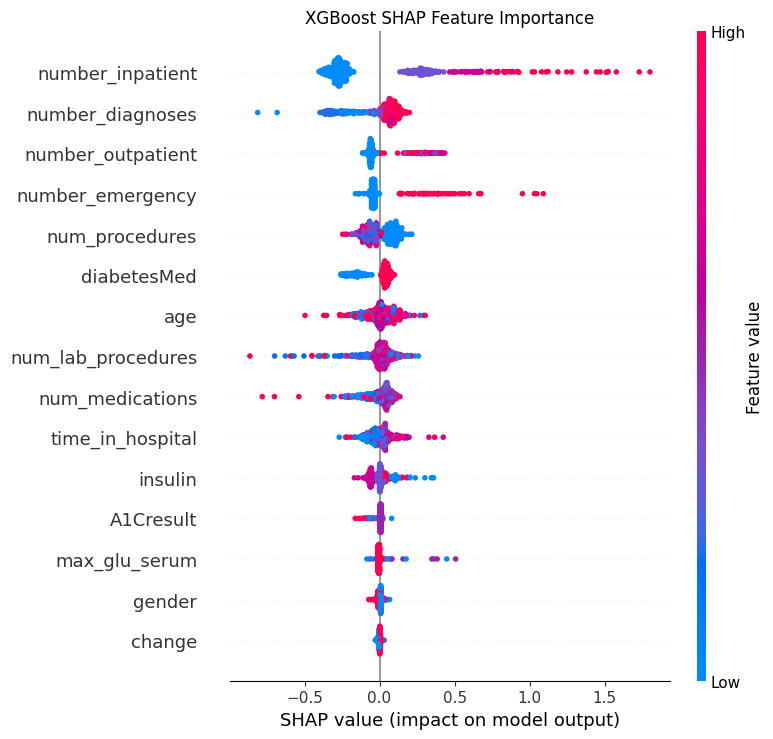

In [21]:
# Cell 16: SHAP analysis for XGBoost
print("Computing SHAP values for XGBoost...")

# Sample 500 rows from X_test for SHAP analysis
X_sample = X_test.sample(n=500, random_state=42)

# Create a TreeExplainer for XGBoost
xgb_explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values (using same sample for consistency)
xgb_shap_values = xgb_explainer.shap_values(X_sample)

print("XGBoost SHAP values computed!")

# Create SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(xgb_shap_values, X_sample, feature_names=selected_features, show=False)
plt.title("XGBoost SHAP Feature Importance")
plt.tight_layout()
plt.show()